In [20]:
#Importing modules
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import math
import random
import os
import operator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
import tensorflow as tf


In [21]:
# Load the dataset
data = pd.read_csv('../Data/features_3_sec.csv')

# Separate features and labels
X = np.array(data.drop(columns=['filename','label','length']))  # Concatenate mean and variance features
y = data['label']  # Target

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [22]:
# Reshape the data for Conv1D input
x_scaler  = StandardScaler()
X_train,X_test = x_scaler.fit_transform(X_train),x_scaler.fit_transform(X_test)
input_dim = X_train.shape[1]
X_train_reshaped = X_train.reshape(X_train.shape[0], input_dim, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], input_dim, 1)

In [23]:
# Build the CNN model
history = History()
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    BatchNormalization(),  
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=512, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the mode
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.1)
model.summary()


Epoch 1/10
225/225 [==============================] - 5s 13ms/step - loss: 1.7104 - accuracy: 0.4349 - val_loss: 2.3768 - val_accuracy: 0.1350
Epoch 2/10
225/225 [==============================] - 3s 12ms/step - loss: 1.1619 - accuracy: 0.6114 - val_loss: 0.9430 - val_accuracy: 0.6913
Epoch 3/10
225/225 [==============================] - 3s 12ms/step - loss: 0.8862 - accuracy: 0.7061 - val_loss: 0.7714 - val_accuracy: 0.7375
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.7280 - accuracy: 0.7663 - val_loss: 0.7052 - val_accuracy: 0.7538
Epoch 5/10
225/225 [==============================] - 3s 12ms/step - loss: 0.5711 - accuracy: 0.8144 - val_loss: 0.5952 - val_accuracy: 0.7975
Epoch 6/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4642 - accuracy: 0.8491 - val_loss: 0.5358 - val_accuracy: 0.8300
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.3921 - accuracy: 0.8797 - val_loss: 0.5279 - val_accuracy: 0.8375

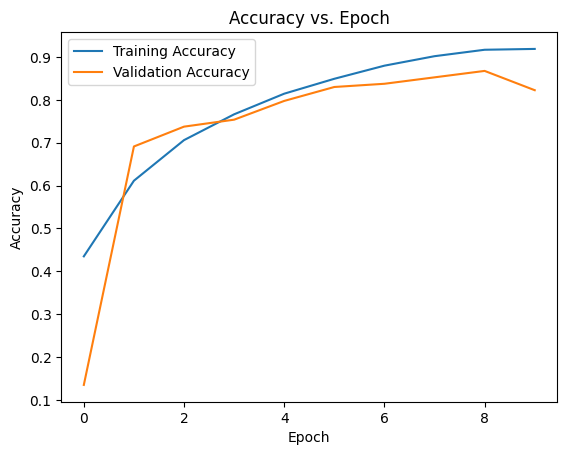

In [24]:
# Plot the accuracy across epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

In [25]:
# Testing the model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.8308
Test Loss: 0.650635838508606
Test Accuracy: 0.8308308124542236


63/63 [==============================] - 0s 3ms/step
Confusion Matrix:
[[170   1  11   6   3  11   0   0   4   2]
 [  2 190   0   0   0  11   0   0   0   0]
 [  9   2 146   7   2   7   1   5   2   5]
 [  4   2   2 156   6   3   0  15   8   3]
 [  2   1   2  14 179   3   1   4  11   1]
 [  1  22   3   0   0 166   0   0   0   0]
 [ 10   0   0   7   3   0 177   0   2   5]
 [  2   0   3   2  11   1   1 158   1   1]
 [  4   1  10   3   7   2   0   3 181   0]
 [ 11   2  13   8   4   5   6   6   5 137]]


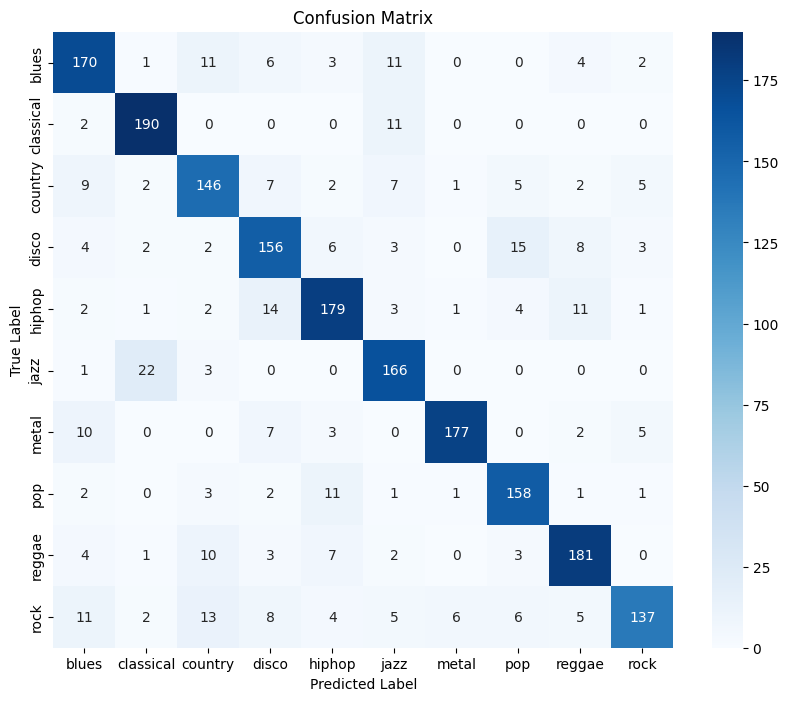

In [27]:
# Evaluate the model
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [28]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       blues       0.79      0.82      0.80       208
   classical       0.86      0.94      0.90       203
     country       0.77      0.78      0.78       186
       disco       0.77      0.78      0.78       199
      hiphop       0.83      0.82      0.83       218
        jazz       0.79      0.86      0.83       192
       metal       0.95      0.87      0.91       204
         pop       0.83      0.88      0.85       180
      reggae       0.85      0.86      0.85       211
        rock       0.89      0.70      0.78       197

    accuracy                           0.83      1998
   macro avg       0.83      0.83      0.83      1998
weighted avg       0.83      0.83      0.83      1998

